In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torchvision.models import inception_v3
from torchvision.transforms import functional as TF
from torchvision import datasets, transforms
from scipy.stats import entropy


from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter


#import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [3]:
FOLDER_PATH = '/content/drive/MyDrive/Deep Learning/ex3_305673212_312349509/FashionMNIST'
if (os.path.exists(FOLDER_PATH)):
  path = FOLDER_PATH
else:
  path = "data" #for git runs

In [176]:
#hyper parameters
#TODO: the WGAN paper states lr= 5e-5, should we use it?
DIM = 64 # Model dimensionality
BATCH_SIZE = 50 # Batch size
CRITIC_ITERS = 5 # For WGAN and WGAN-GP, number of critic iters per gen iter
LAMBDA = 10 # Gradient penalty lambda hyperparameter
GEN_ITERS = 200000 # How many generator iterations to train for
LATENT_DIM = 128
in_channels = 1
input_img_w = 28 #FashionMNIST Width
input_img_h = 28 #FashionMNIST Hight
OUTPUT_DIM = input_img_w*input_img_h # Number of pixels in MNIST (28*28)
CIFAR_SIZE = (32,32)


# W&B





In [4]:
#TODO: remove before submission
import wandb
from mycreds import WANDB_API_KEY
wandb.login(key=WANDB_API_KEY)



wandb: Currently logged in as: nadavo11 (nadavoteam). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\nadav\_netrc


True

# Data Preprocessing
## Data loaders
let's prepare our data by loading it, normalizing it, and creating the data loaders.

In [178]:
""
# Define the transform to convert the images to tensors and normalize them and resize them to 32X32 to match CIFAR input

transform = transforms.Compose([
    transforms.Resize(CIFAR_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Download and load the training data
train_dataset = datasets.FashionMNIST(root=path, train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root=path, train=False, download=True, transform=transform)

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_iter = iter(train_loader)

# Network Architecture
We will implemnet gernerator and descriminator/critic as defined in "Improved Training of Wasserstein GANs" papaer for CIFAR10We decided to resize the FashionMNIST images from 28X28X1 to 32X32X1 to be able to use same conv layers used in the paper



# generator

### conv dimensions
convolution dimensions are calculated as follows: $ x = \frac{W - k + 2P}{S} + 1 $ deconv dimensions are calculated as follows: $ x = S(W-1) + k - 2P + F $ where: - W is the input image size - k is the kernel size - P is the padding - S is the stride - F is the output padding


In [179]:

#Input to Generator is noise which can be random or not, nosie dimention is 128

class Generator(nn.Module):

    def __init__(self,
                 dim=DIM,
                 latent_dim = LATENT_DIM):

        super(Generator, self).__init__()

        self.dim = dim
        self.latent_dim = latent_dim

        # 1. Fully connected:
        # 128 -> 4*4*4*dim
        self.linear = nn.Linear(latent_dim,
                                4*4*4*dim)

        self.bn1 = nn.BatchNorm1d(4*4*4*dim)

        # 2. deConv
        # (4x4) 4dim -> (8x8) 2dim
        self.deconv2 = nn.ConvTranspose2d(4*dim,
                                          2*dim,
                                          kernel_size=5,
                                          stride=2,
                                          padding=2,
                                          output_padding=1)
        self.bn2 = nn.BatchNorm2d(2*dim)

        # 3. deConv
        # (8x8) 2dim -> (16x16) dim
        self.deconv3 = nn.ConvTranspose2d(2*dim,
                                          dim,
                                          kernel_size=5,
                                          stride=2,
                                          padding=2,
                                          output_padding=1)
        self.bn3 = nn.BatchNorm2d(dim)

        # 4. deConv
        #(16x16) dim -> (32X32) 1
        self.deconv4 = nn.ConvTranspose2d(dim,
                                          in_channels,
                                          kernel_size=5,
                                          stride=2,
                                          padding=2,
                                          output_padding=1)


    # TODO : complete forward function
    #  check if we need to add noise to the forward function
    def forward(self, n_samples, noise=None):
        if noise is None:
            noise = torch.randn(n_samples, self.latent_dim).to(device)

        # 1. Fully connected
        output = self.linear(noise)
        output = self.bn1(output)
        output = F.relu(output)
        output = output.view(-1, 4*self.dim, 4, 4)

        # 2.Deconv
        output = self.deconv2(output)
        output = self.bn2(output)
        output = F.relu(output)

        # 3. Deconv
        output = self.deconv3(output)
        output = self.bn3(output)
        output = F.relu(output)

        # 4. Deconv
        output = self.deconv4(output)
        output = torch.tanh(output)

        return output






 # Discriminator

convolution dimensions are calculated as follows: $ x = \frac{W - k + 2P}{S} + 1 $ deconv dimensions are calculated as follows: $ x = S(W-1) + k - 2P + F $ where: - W is the input image size - k is the kernel size - P is the padding - S is the stride - F is the output padding

In [198]:
class Discriminator(nn.Module):
    def __init__(self,
                dim = DIM,
                in_channels = 1):

        super(Discriminator, self).__init__()
        self.in_features = in_channels
        self.dim=dim
        self.conv1 = nn.Conv2d(kernel_size=5,
                             in_channels=in_channels,
                             out_channels=self.dim,
                             stride=2,) # dimX14X4

        self.conv2 = nn.Conv2d(kernel_size=5,
                                in_channels=self.dim,
                                out_channels=2*self.dim,
                                stride=2,) # 2dimX5X5
        self.batch_norm2 = nn.BatchNorm2d(2*self.dim)

        self.conv3 = nn.Conv2d(kernel_size=1,
                                in_channels=2*self.dim,
                                out_channels=4*self.dim,
                                stride=1,) # 4dimX5X5
        self.batch_norm3 = nn.BatchNorm2d(4*self.dim)

        self.fc = nn.Linear(4*5*5*self.dim, 1)


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = x.view(-1, 4*5*5*self.dim)  # Flatten
        x = self.fc(x)
        return x


In [9]:
class GAN(nn.Module):
    def __init__(self,
                 dim=DIM,
                 mode='wgan',
                 latent_dim=LATENT_DIM,
                 ):
        super(GAN, self).__init__()
        self.generator = Generator(dim = dim,
                                   mode = mode,
                                   latent_dim= latent_dim)
        self.discriminator = Discriminator(dim = dim,
                                           mode = mode,in_channels=in_channels)


# Evaluation
we define our evaluation metric as the inception score:

In [148]:
# Inception score (Evaluation)
def inception_score(images, batch_size=32, splits=10):
    # Load pre-trained InceptionV3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).eval()
    
    def get_pred(x):
        with torch.no_grad():
            x = inception_model(x)
        return F.softmax(x, dim=1).cpu().numpy()
    
    # Resize images to 299x299 as required by InceptionV3
    images = [TF.resize(img, (299, 299)) for img in images]
    images = torch.stack(images)
    
    # Calculate predictions
    preds = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        preds.append(get_pred(batch))
    preds = np.concatenate(preds, axis=0)
    
    # Calculate Inception Score
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores), np.std(split_scores)

def disc_cost (mode,disc_fake,disc_real):
    return (torch.mean(disc_fake) - torch.mean(disc_real) if mode == 'wgan' else \
                            (F.binary_cross_entropy_with_logits(disc_fake, torch.zeros_like(disc_fake)) +
                                F.binary_cross_entropy_with_logits(disc_real, torch.ones_like(disc_real))) / 2.)

def gen_cost(disc_fake,mode):
    return (-torch.mean(disc_fake) if mode == 'wgan' else F.binary_cross_entropy_with_logits(disc_fake, torch.ones_like(disc_fake)))

#### Test the generator
can be removed before submission

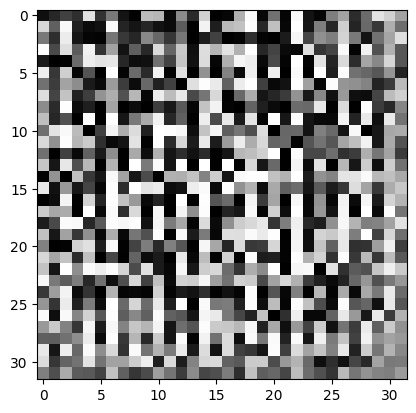

In [187]:
generator = Generator()
img = generator.forward(15)


plt.imshow(img[0].transpose(0,2).detach().numpy(), cmap='gray')
plt.show()

#Lost Function/ Inception

In [203]:

class GAN:
    def __init__(self, generator, discriminator, mode, train_loader, val_loader, gen_iters, critic_iters, batch_size = BATCH_SIZE):
        self.generator = generator 
        self.discriminator = discriminator 
        self.mode = mode
        self.gen_optimizer = optim.RMSprop(self.generator.parameters(), lr=5e-5)
        self.disc_optimizer = optim.RMSprop(self.discriminator.parameters(), lr=5e-5)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.gen_iters =gen_iters
        self.critic_iters = critic_iters
        self.batch_size = batch_size

    # NADAV/REUT: Do we need to defrenciate the optimizers?
 #   self.setup_optimizers()

    #def setup_optimizers(self):
    #     if self.mode == 'wgan':
    #         self.gen_optimizer = optim.RMSprop(self.generator.parameters(), lr=5e-5)
    #         self.disc_optimizer = optim.RMSprop(self.discriminator.parameters(), lr=5e-5)
    #     elif self.mode == 'dcgan':
    #         self.gen_optimizer = optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    #         self.disc_optimizer = optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

  #TODO: Consider change it if training is too heavey 
    def inf_train_gen(self):
        while True:
            for images, _ in self.train_loader:
                yield images


    def train(self):
        for iteration in range(self.gen_iters):
            start_time = time.time()
            # Train generator
            self.gen_optimizer.zero_grad()
            fake_data = self.generator(self.batch_size)
            disc_fake = self.discriminator(fake_data)
            gen_cost_val = gen_cost(mode=self.mode,disc_fake=disc_fake )
            gen_cost_val.backward()
            self.gen_optimizer.step()

            # Train critic/dicriminator
            disc_iters = 1 if self.mode == 'dcgan' else self.critic_iters
            for _ in range(disc_iters):
                _data = next(self.inf_train_gen()).to(device)
                self.disc_optimizer.zero_grad()
                disc_real = self.discriminator(_data)
                fake_data = self.generator(self.batch_size)
                disc_fake = self.discriminator(fake_data)

                disc_cost_val =disc_cost(mode=self.mode,disc_real=disc_real,disc_fake=disc_fake) 
                disc_cost_val.backward()
                self.disc_optimizer.step()

                if self.mode == 'wgan':
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)
                        
            print(f"Iteration {iteration}, Generator Cost: {gen_cost_val}, Discriminator Cost: {disc_cost_val} Time: {time.time() - start_time}")

            # Logging

            # Calculate inception score every 1K iters
            if iteration % 1000 == 999:
                with torch.no_grad():
                    z = torch.randn(1000, 100, 1, 1).to(device)
                    generated_imgs = generator(z)
                    generated_imgs = generated_imgs.cpu()
                    inception_mean, inception_std = inception_score(generated_imgs)
                    print(f"Genrator Iteration {iteration}: Inception Score: {inception_mean} ± {inception_std}")
                    img = generator.forward(10)
                    plt.imshow(img[0].transpose(0,2).detach().numpy(), cmap='gray')
                    plt.show()

            # Calculate val loss of the discriminator and generate samples every 100 iters
            if iteration % 100 == 99:
                val_disc_costs = []
                for images, _ in self.val_loader:
                    images = torch.tensor(images).float()  # Convert images to a PyTorch tensor
                    fake_data = self.generator(self.batch_size)
                    disc_fake = self.discriminator(fake_data)
                    _dev_disc_cost = disc_cost(mode=self.mode,disc_real=images,disc_fake=disc_fake)  # Compute the discriminator cost
                    val_disc_costs.append(_dev_disc_cost.item())  # Append the cost to the list
                mean_dev_disc_cost = np.mean(val_disc_costs) #TODO plot

    
                







In [204]:
dc_gen=Generator(dim = DIM,latent_dim= LATENT_DIM)
dc_disc = Discriminator(dim = DIM,in_channels=in_channels)
dcgan = GAN(mode = 'dcgan'
            , train_loader=train_loader
            , gen_iters = GEN_ITERS
            , critic_iters=CRITIC_ITERS
            ,batch_size = BATCH_SIZE
            ,discriminator = dc_disc
            ,generator = dc_gen
            ,val_loader=test_loader)
dcgan.train()

Iteration 0, Generator Cost: 0.7348595261573792, Discriminator Cost: 1.1095303297042847 Time: 1.6824288368225098
Iteration 1, Generator Cost: 2.6257317066192627, Discriminator Cost: 0.6569658517837524 Time: 0.3909926414489746
Iteration 2, Generator Cost: 2.3675899505615234, Discriminator Cost: 0.7768301963806152 Time: 0.37479066848754883
Iteration 3, Generator Cost: 2.268214464187622, Discriminator Cost: 0.5312726497650146 Time: 0.3556523323059082
Iteration 4, Generator Cost: 2.2292985916137695, Discriminator Cost: 0.5633546113967896 Time: 0.6164097785949707
Iteration 5, Generator Cost: 1.9984145164489746, Discriminator Cost: 0.543925940990448 Time: 0.9483444690704346
Iteration 6, Generator Cost: 1.8418936729431152, Discriminator Cost: 0.5731967091560364 Time: 0.38655805587768555
Iteration 7, Generator Cost: 1.748278021812439, Discriminator Cost: 0.5034918785095215 Time: 0.3570435047149658
Iteration 8, Generator Cost: 1.7690112590789795, Discriminator Cost: 0.645229160785675 Time: 0.36

C:\Users\reuts\AppData\Local\Temp\ipykernel_24184\1325811456.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).float()  # Convert images to a PyTorch tensor


Iteration 100, Generator Cost: 2.555795669555664, Discriminator Cost: 0.15564575791358948 Time: 0.390796422958374
Iteration 101, Generator Cost: 2.6103811264038086, Discriminator Cost: 0.12265787273645401 Time: 0.410494327545166
Iteration 102, Generator Cost: 2.605031967163086, Discriminator Cost: 0.1384369432926178 Time: 0.41831326484680176
Iteration 103, Generator Cost: 2.6453566551208496, Discriminator Cost: 0.14243890345096588 Time: 0.36763620376586914
Iteration 104, Generator Cost: 2.6144869327545166, Discriminator Cost: 0.1835012137889862 Time: 0.4323148727416992
Iteration 105, Generator Cost: 2.593388557434082, Discriminator Cost: 0.1481555998325348 Time: 0.45316219329833984
Iteration 106, Generator Cost: 2.6421616077423096, Discriminator Cost: 0.13692985475063324 Time: 0.4575684070587158
Iteration 107, Generator Cost: 2.555687189102173, Discriminator Cost: 0.16948093473911285 Time: 0.39868664741516113
Iteration 108, Generator Cost: 2.6335549354553223, Discriminator Cost: 0.1638